In [96]:
!pip install sphinx
!pip install pykeops[full] > install.log
import matplotlib.pyplot as plt

import pykeops
pykeops.clean_pykeops()
import time
import torch
from pykeops.torch import LazyTensor
import numpy as np
from pykeops.torch.cluster import cluster_ranges_centroids
from pykeops.torch.cluster import sort_clusters
from pykeops.torch.cluster import from_matrix
use_cuda = torch.cuda.is_available()
dtype = torch.float32 if use_cuda else torch.float64
if use_cuda:
    torch.cuda.synchronize()

Cleaning /root/.cache/pykeops-1.4.2-cpython-36/...
    - /root/.cache/pykeops-1.4.2-cpython-36/libKeOpstorcha49c4bfa8c.so has been removed.
    - /root/.cache/pykeops-1.4.2-cpython-36/libKeOpstorch29a3621b4f.cpython-36m-x86_64-linux-gnu.so has been removed.
    - /root/.cache/pykeops-1.4.2-cpython-36/libKeOpstorch29a3621b4f.so has been removed.
    - /root/.cache/pykeops-1.4.2-cpython-36/libKeOpstorch12a47ed644.cpython-36m-x86_64-linux-gnu.so has been removed.
    - /root/.cache/pykeops-1.4.2-cpython-36/keops_hash.log has been removed.
    - /root/.cache/pykeops-1.4.2-cpython-36/libKeOpstorcha49c4bfa8c.cpython-36m-x86_64-linux-gnu.so has been removed.
    - /root/.cache/pykeops-1.4.2-cpython-36/libKeOpstorch12a47ed644.so has been removed.


In [73]:
def KMeans(x, K=10, Niter=15, verbose=False):
    """Implements Lloyd's algorithm for the Euclidean metric."""

    start = time.time()
    N, D = x.shape  # Number of samples, dimension of the ambient space

    c = x[:K, :].clone()  # Simplistic initialization for the centroids

    x_i = LazyTensor(x.view(N, 1, D))  # (N, 1, D) samples
    c_j = LazyTensor(c.view(1, K, D))  # (1, K, D) centroids

    # K-means loop:
    # - x  is the (N, D) point cloud,
    # - cl is the (N,) vector of class labels
    # - c  is the (K, D) cloud of cluster centroids
    for i in range(Niter):

        # E step: assign points to the closest cluster -------------------------
        D_ij = ((x_i - c_j) ** 2).sum(-1)  # (N, K) symbolic squared distances
        cl = D_ij.argmin(dim=1).long().view(-1)  # Points -> Nearest cluster

        # M step: update the centroids to the normalized cluster average: ------
        # Compute the sum of points per cluster:
        c.zero_() #sets c to 0
        #scatter_add_(dim,index,src) 
        #https://pytorch-scatter.readthedocs.io/en/1.3.0/functions/add.html
        #adds elements of a source by allocating using a indexing vector
        c.scatter_add_(0, cl[:, None].repeat(1, D), x) #[50,2], obtains the sum of all values that are in the same cluster
        #repeat basically duplicates the whole vector once and concatenates to itself

        # Divide by the number of points per cluster:
        Ncl = torch.bincount(cl, minlength=K).type_as(c).view(K, 1)#bincount gives number of bins per cluster
        c /= Ncl  # in-place division to compute the average

    if verbose:  # Fancy display -----------------------------------------------
        if use_cuda:
            torch.cuda.synchronize()
        end = time.time()
        print(
            f"K-means for the Euclidean metric with {N:,} points in dimension {D:,}, K = {K:,}:"
        )
        print(
            "Timing for {} iterations: {:.5f}s = {} x {:.5f}s\n".format(
                Niter, end - start, Niter, (end - start) / Niter
            )
        )

    return cl, c

def k_argmin(x,y,k=5):
  x_LT=LazyTensor(x.unsqueeze(1))
  y_LT=LazyTensor(y.unsqueeze(0))
  d=((x_LT-y_LT)**2).sum(-1)
  return d.argmin(dim=1).long().view(-1)   

def k_argmin_torch(x,y,k=5):
  d=((x.unsqueeze(1)-y.unsqueeze(0))**2).sum(-1)
  sort,idx=torch.sort(d,dim=1)
  return idx[:,:k]   

In [84]:
class IVF_flat():
  def __init__(self,k=5):
    self.c=None
    self.cl=None
    self.k=k
    self.ncl=None
    self.x=None
    self.keep=None
    self.x_ranges=None
  def fit(self,x,use_torch=True,clusters=50,a=5):
    
    cl, c = KMeans(x,clusters)

    self.c=c
    #update cluster assignment
    if use_torch:
      d=((x.unsqueeze(1)-c.unsqueeze(0))**2).sum(-1)
      self.cl=torch.argmin(d,dim=1)
    else:
      self.cl=k_argmin(x,c)
    if use_cuda:
        torch.cuda.synchronize()

    #get KNN graph for the clusters
    if use_torch:

      self.ncl=k_argmin_torch(c,c,k=a)
    else:
        
      c1=LazyTensor(c.unsqueeze(1)) 
      c2=LazyTensor(c.unsqueeze(0))
      d=((c1-c2)** 2).sum(-1)
      self.ncl=d.argKmin(K=a,dim=1) #get a nearest clusters

    #get the ranges and centroids 
    self.x_ranges, _, _ = cluster_ranges_centroids(x, self.cl)

    #
    
    x, x_labels = sort_clusters(x,self.cl) #sort dataset to match ranges
    self.x=LazyTensor(x.unsqueeze(1))#store dataset
      
    r=torch.arange(clusters).repeat(a,1).T.reshape(-1).long()
    self.keep= torch.zeros([clusters,clusters], dtype=torch.bool)    
   
    self.keep[r,self.ncl.flatten()]=True        

    return self
  def sorted(self,x,labels=None):
    if labels is None:
      labels=self.cl
    x,_=sort_clusters(x,labels)
    return x
  def clusters(self):
    return self.c
  def assign(self,x,c=None):
    if c is None:
      c=self.c
    return k_argmin(x,c,self.k)
    
  def kneighbors(self,y):
    if use_cuda:
        torch.cuda.synchronize()
    d=((y.unsqueeze(1)-self.c.unsqueeze(0))**2).sum(-1)
    y_labels=torch.argmin(d,dim=1)

    y_ranges,_,_ = cluster_ranges_centroids(y, self.cl)
    
    y, y_labels = sort_clusters(y, y_labels)   
    
    ranges_ij = from_matrix(self.x_ranges, y_ranges, self.keep)    

    y_LT=LazyTensor(y.unsqueeze(0))
    D_ij=((y_LT-self.x)**2).sum(-1) 
    D_ij.ranges=ranges_ij
    return D_ij.argKmin(K=self.k,axis=1)

In [112]:
#get ground truth label
torch.manual_seed(0)
N, D, K , k= 10**6, 3, 50,5
x = 0.7 * torch.randn(N, D, dtype=dtype) + 0.3
y = 0.7 * torch.randn(N, D, dtype=dtype) + 0.3

test=IVF_flat()
test.fit(x)
x=test.sorted(x)
labels=test.assign(y)
y=test.sorted(y,labels)
test=IVF_flat()
test.fit(x)
x_LT=LazyTensor(x.unsqueeze(1))
y_LT=LazyTensor(y.unsqueeze(0))
D_ij=((y_LT-x_LT)**2).sum(-1) 
ground_truth=D_ij.argKmin(K=k,axis=1)

In [113]:
ground_truth

tensor([[  6329,   9831,   9597,  10811,   4563],
        [  4832,   5524,  12924,   3853,   9790],
        [  7903,   5699,  12175,   7535,   3580],
        ...,
        [993170, 990414, 997962, 988703, 995487],
        [993393, 992175, 989179, 992743, 988151],
        [987228, 998257, 987172, 996429, 990372]])

In [118]:
#reset sorted data
torch.manual_seed(0)
N, D, K , k= 10**6, 3, 50,5
x = 0.7 * torch.randn(N, D, dtype=dtype) + 0.3
y = 0.7 * torch.randn(N, D, dtype=dtype) + 0.3

In [119]:
#varying a, number of clusters to search over
fit_times=[]
search_times=[]
acc_list=[]
r=range(1,11)
for a in r:
  print('Testing a =',str(a))
  start=time.time()
  t=IVF_flat()
  t.fit(x,a=a)
  fit_times.append(time.time()-start)
  start=time.time()
  z=t.kneighbors(y)
  search_times.append(time.time()-start)
  acc=torch.count_nonzero(z==ground_truth[:,:k])/(N*k)
  acc_list.append(float(acc))

Testing a = 1
Testing a = 2
Testing a = 3
Testing a = 4
Testing a = 5
Testing a = 6
Testing a = 7
Testing a = 8
Testing a = 9
Testing a = 10


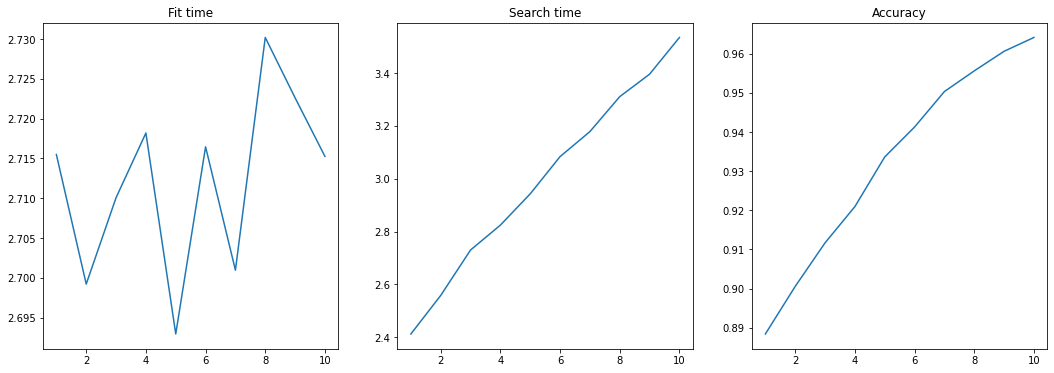

In [120]:
plt.figure(figsize=[18,6])
plt.subplot(1,3,1)
plt.title('Fit time')

plt.plot(list(r),fit_times)
plt.subplot(1,3,2)
plt.title('Search time')
plt.plot(list(r),search_times)
plt.subplot(1,3,3)
plt.title('Accuracy')
plt.plot(list(r),acc_list)
plt.show()

#this is NOT accurate, as it does not include compiling time
#how do I get the compiling time? is there a reset?

In [ ]:
#crashed upon size 10**7 
#need to fix this or we can't BM large sets
torch.manual_seed(0)
N, D, K = 10**7, 3, 50

x = 0.7 * torch.randn(N, D, dtype=dtype) + 0.3
y = 0.7 * torch.randn(N, D, dtype=dtype) + 0.3
start=time.time()
t=IVF_flat()
t.fit(x)
print('fit time',time.time()-start)
start=time.time()
t.kneighbors(y)
print('search time:',time.time()-start)